<a href="https://www.kaggle.com/code/uom180281j/ml-project-eda?scriptVersionId=116424196" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import warnings, gc
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_feather('../input/amexfeather/train_data.ftr')
# Keep the latest statement features for each customer
df_train = df_train.groupby('customer_ID').tail(1).set_index('customer_ID')

df_test = pd.read_feather('../input/amexfeather/test_data.ftr')
# Keep the latest statement features for each customer
df_test = df_test.groupby('customer_ID').tail(1).set_index('customer_ID')

df_subm = pd.read_csv("../input/amex-default-prediction/sample_submission.csv")

In [3]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total amount of rows (Train):', df_train_row_count)
print('Total amount of columns (Train):', df_train_column_count)

Total amount of rows (Train): 458913
Total amount of columns (Train): 190


In [4]:
df_test_row_count, df_test_column_count=df_test.shape
print('Total amount of rows (Test):', df_test_row_count)
print('Total amount of columns (Test):', df_test_column_count)

Total amount of rows (Test): 924621
Total amount of columns (Test): 189


In [5]:
df_train.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Data columns (total 190 columns):
 #    Column  Non-Null Count   Dtype         
---   ------  --------------   -----         
 0    S_2     458913 non-null  datetime64[ns]
 1    P_2     455944 non-null  float16       
 2    D_39    458913 non-null  float16       
 3    B_1     458913 non-null  float16       
 4    B_2     458882 non-null  float16       
 5    R_1     458913 non-null  float16       
 6    S_3     373943 non-null  float16       
 7    D_41    458882 non-null  float16       
 8    B_3     458882 non-null  float16       
 9    D_42    59910 non-null   float16       
 10   D_43    324591 non-null  float16       
 11   D_44    436618 non-null  float16       
 12   B_4     458913 non-null  float16       
 13   D_45    458882 non-null  float16       
 14   B_5     458913 non-null  float

### Checking Null Counts

In [5]:
# Check for number of missing values
df_train.isnull().sum()

S_2            0
P_2         2969
D_39           0
B_1            0
B_2           31
           ...  
D_142     378598
D_143       2830
D_144          0
D_145       2830
target         0
Length: 190, dtype: int64

### Numerical Features

175


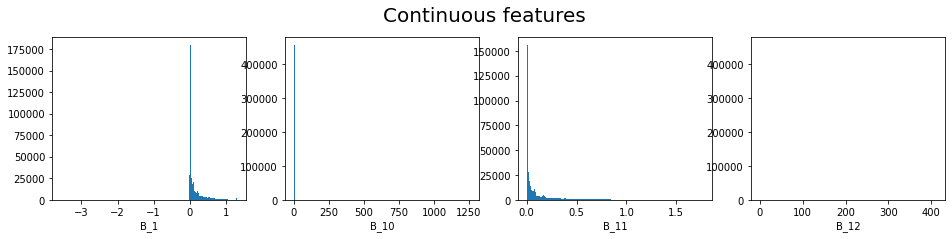

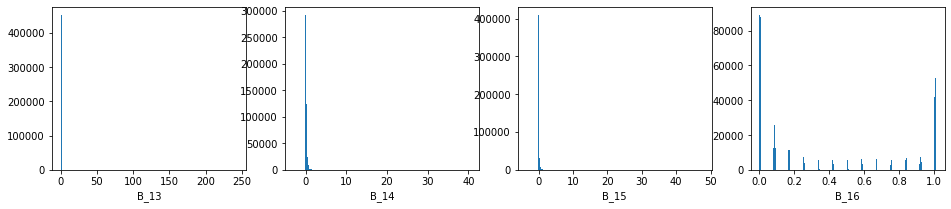

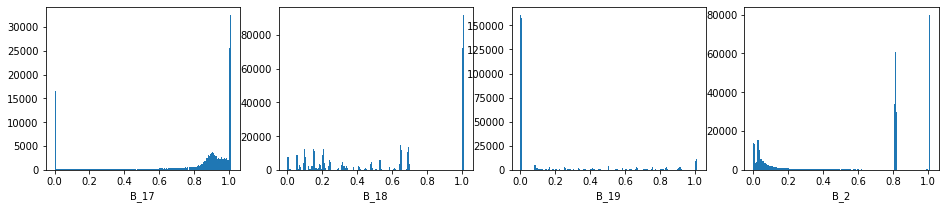

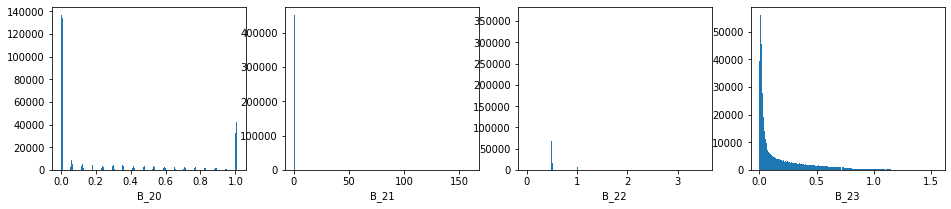

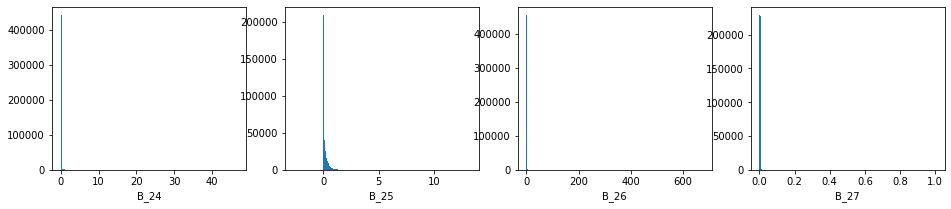

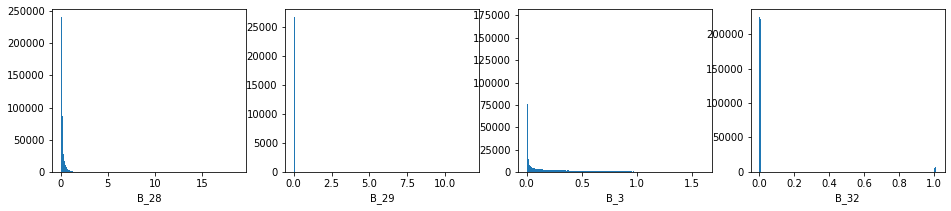

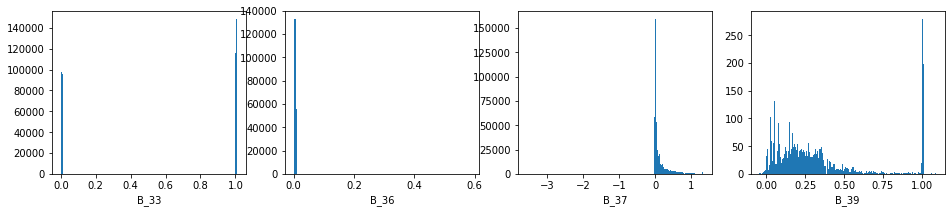

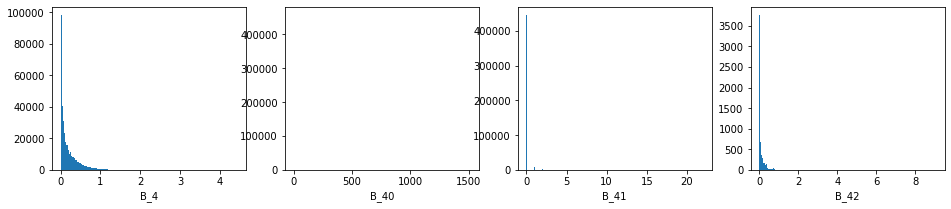

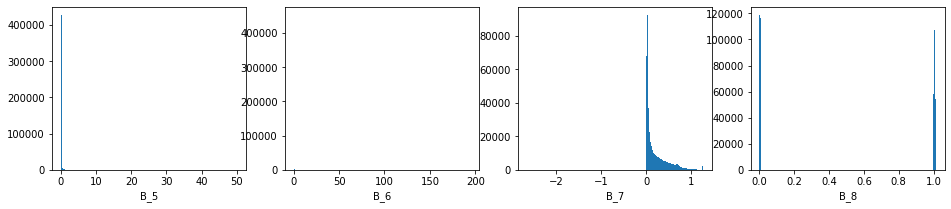

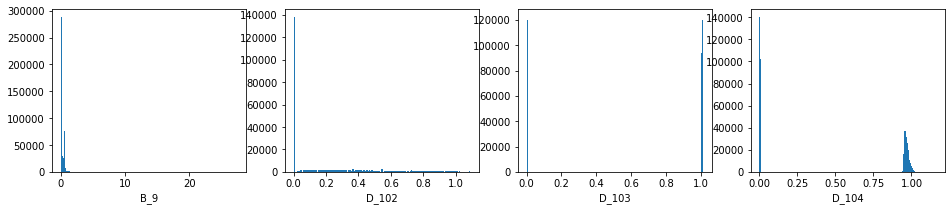

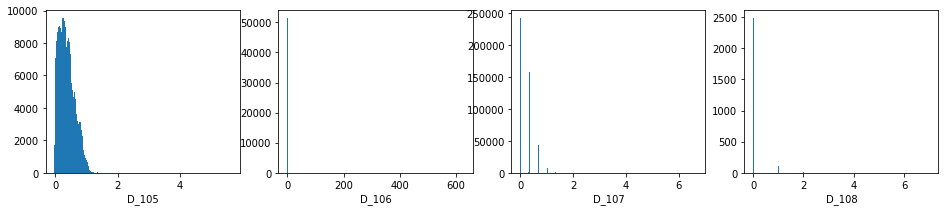

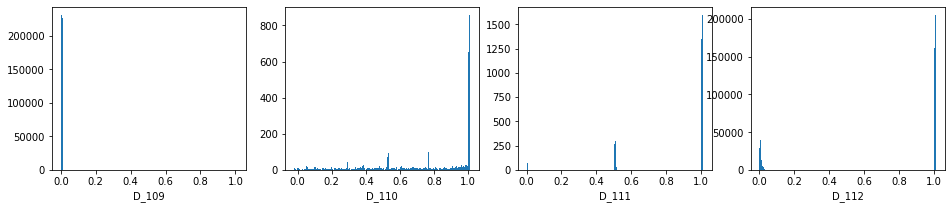

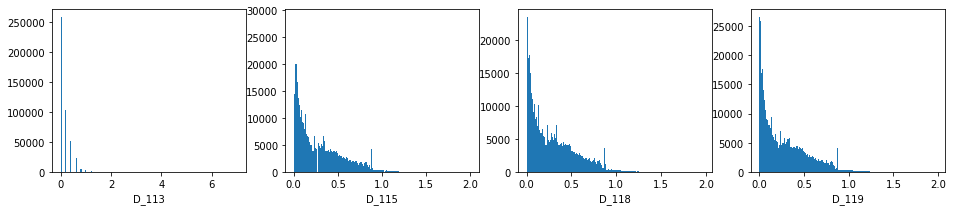

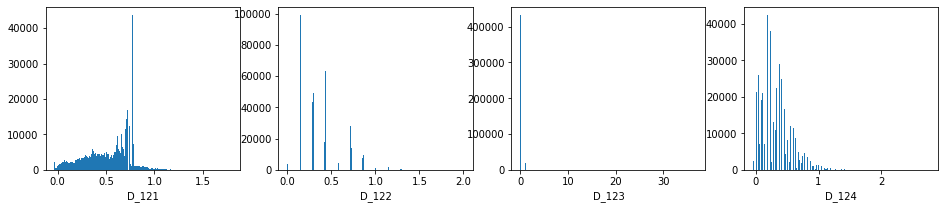

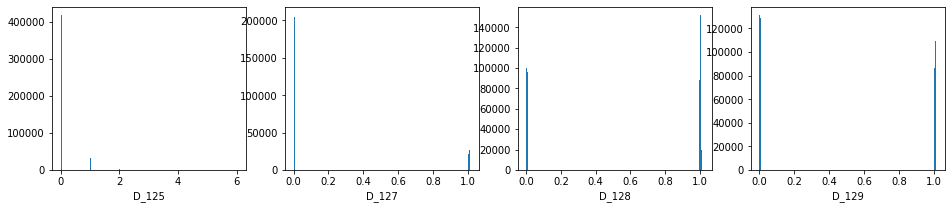

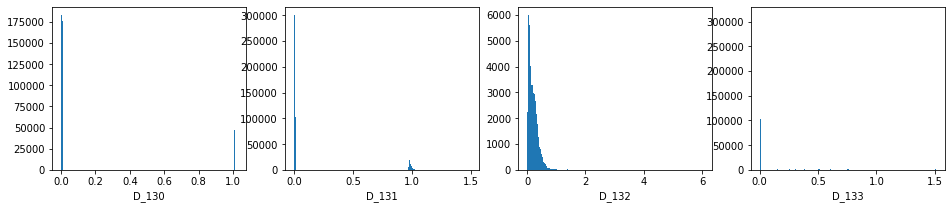

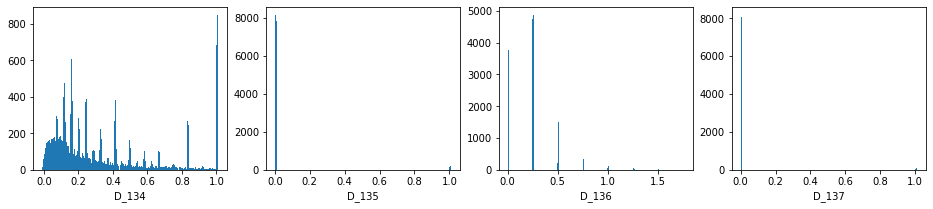

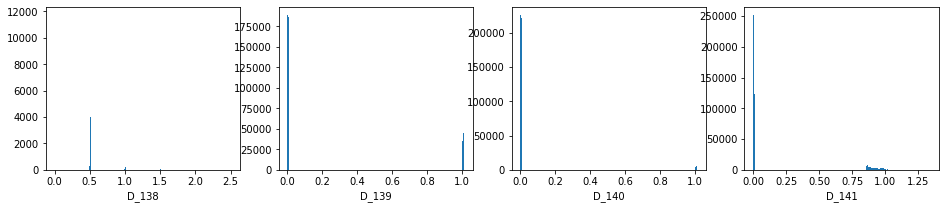

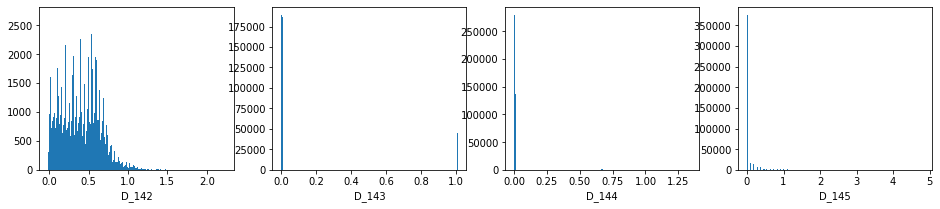

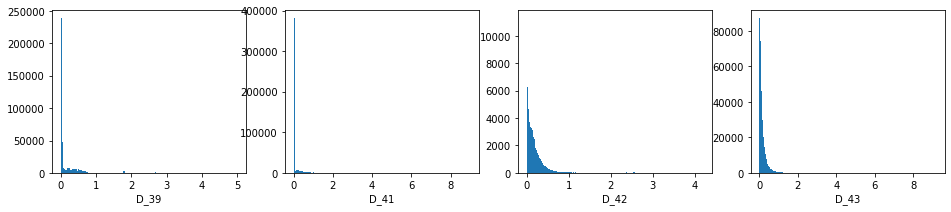

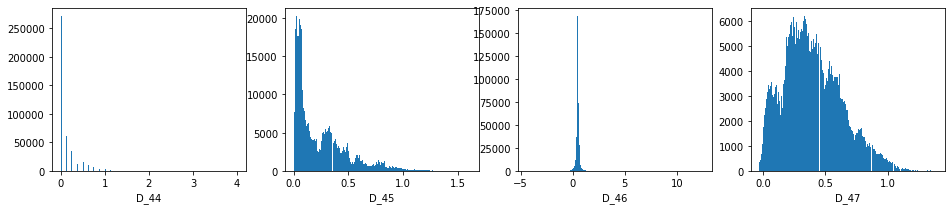

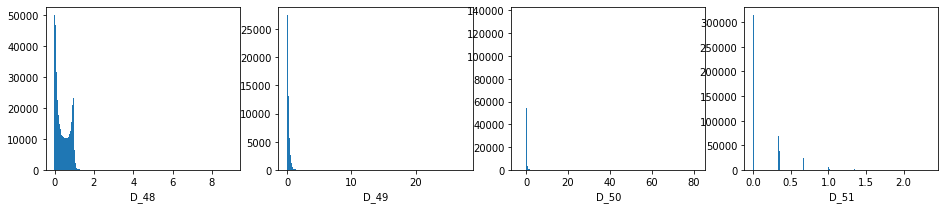

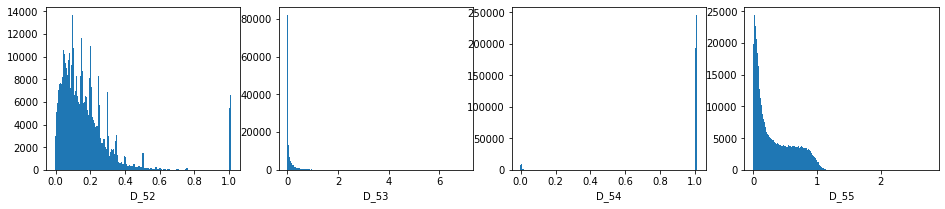

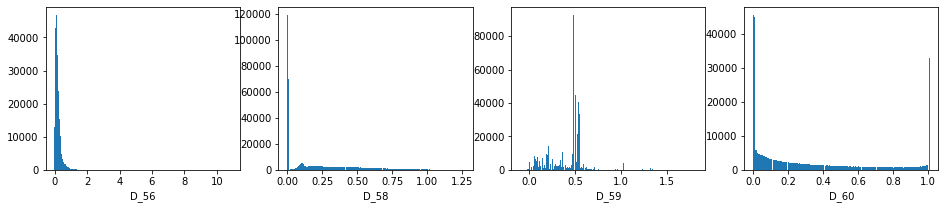

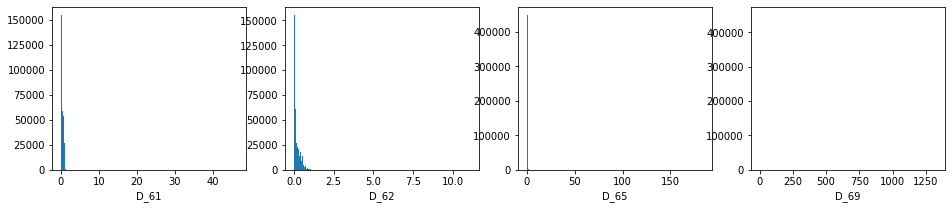

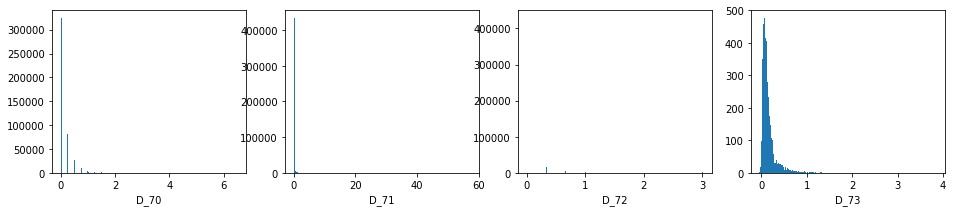

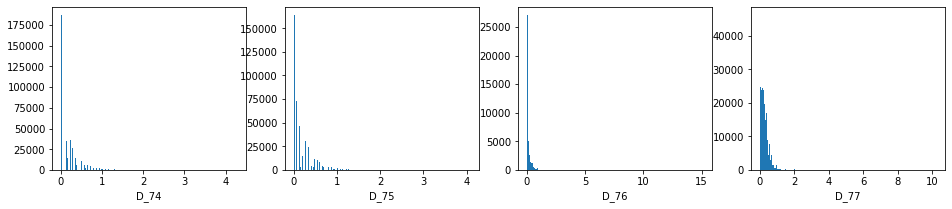

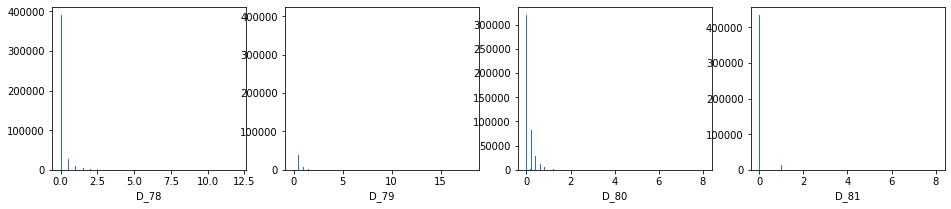

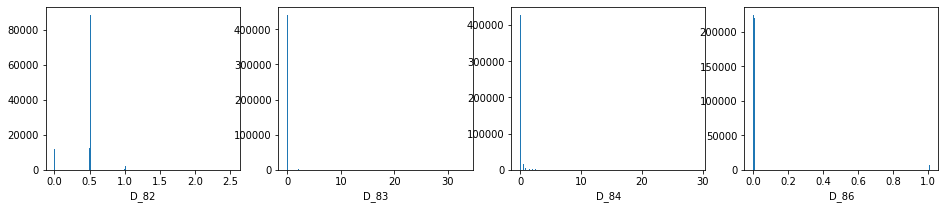

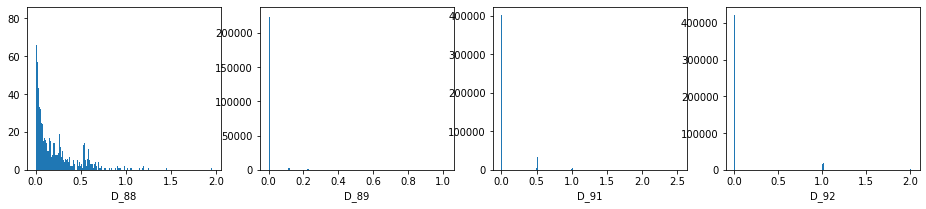

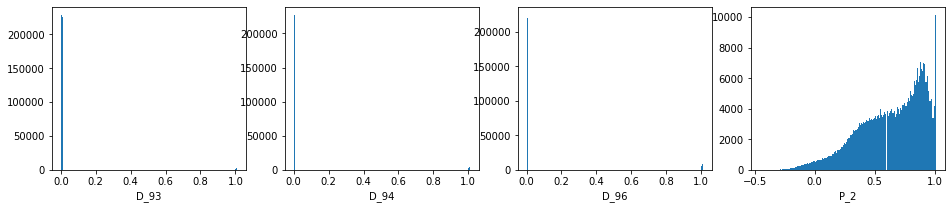

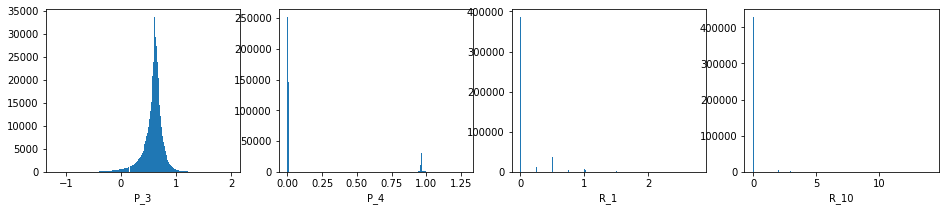

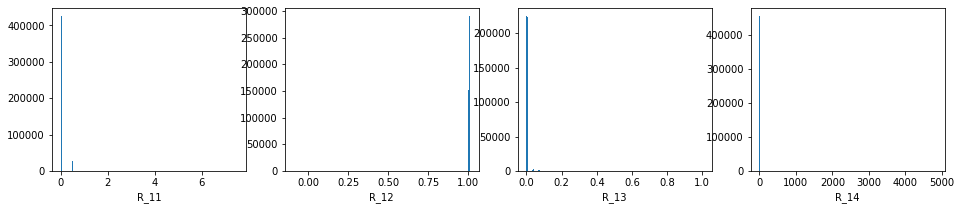

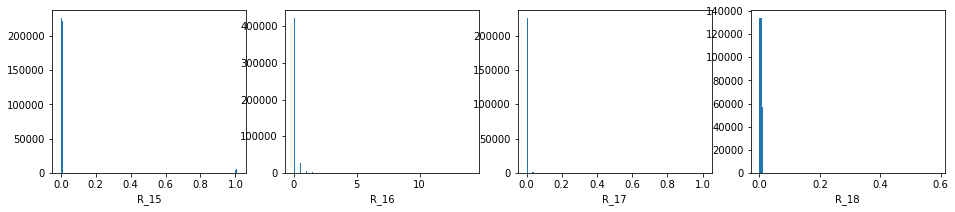

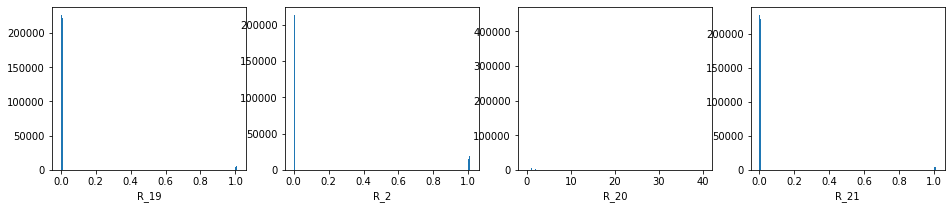

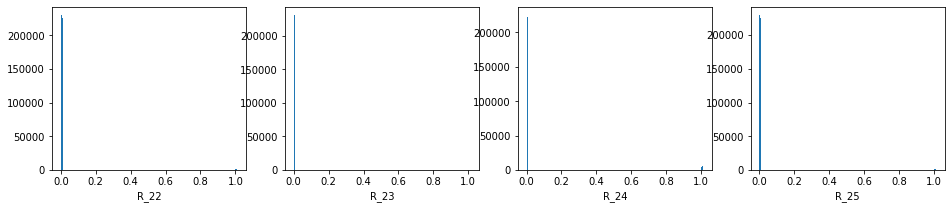

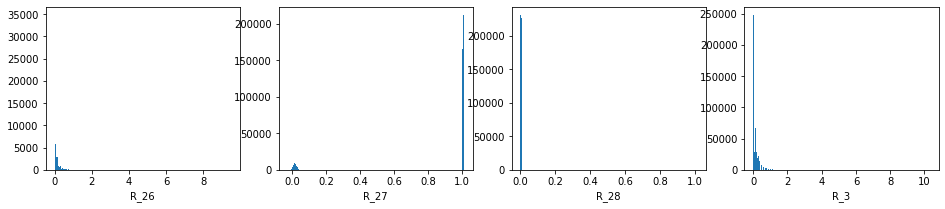

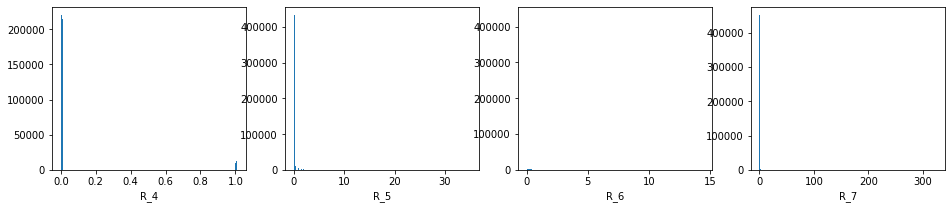

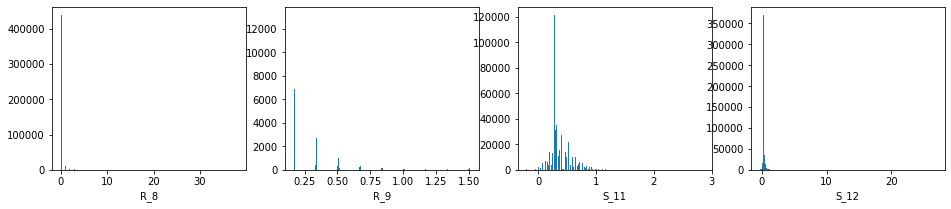

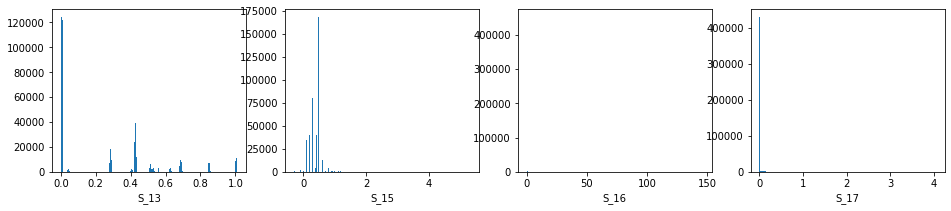

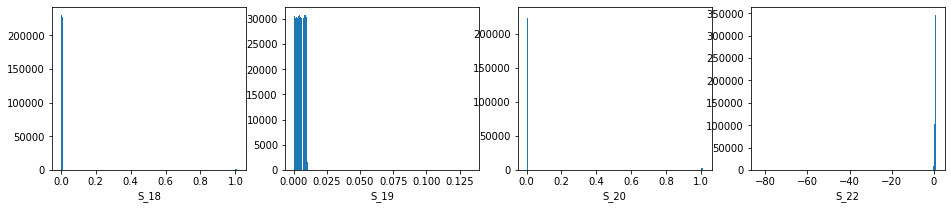

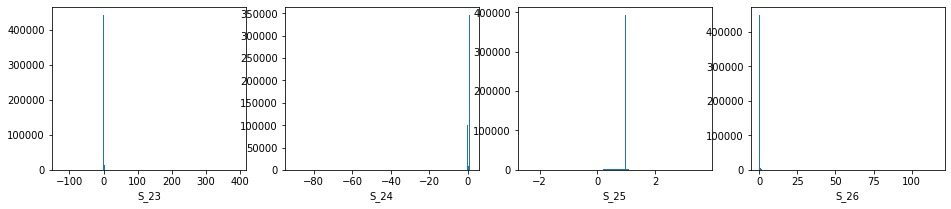

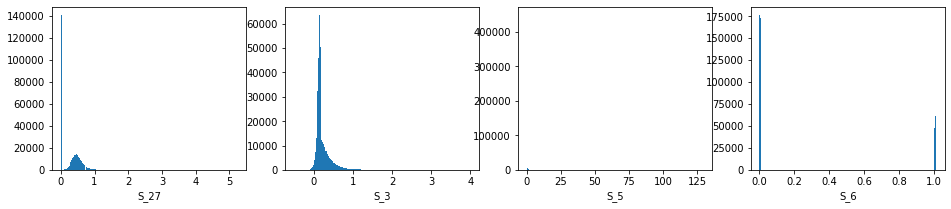

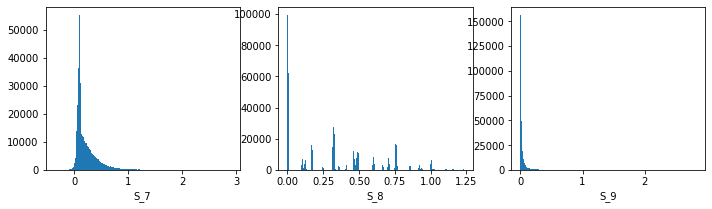

In [14]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
bin_features = ['B_31', 'D_87']
cont_features = sorted([f for f in df_train.columns if f not in cat_features + bin_features + ['customer_ID', 'target', 'S_2']])
print(len(cont_features))
# print(cont_features)
ncols = 4
for i, f in enumerate(cont_features):
    if i % ncols == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(16, 3))
        if i == 0: plt.suptitle('Continuous features', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    plt.hist(df_train[f], bins=200)
    plt.xlabel(f)
plt.show()

### Categorical Variables

In [15]:
#Identify columns which are not numeric
df_train.select_dtypes(include = "category")

,D_63,D_64,D_66,D_68,B_30,B_38,D_114,D_116,D_117,D_120,D_126
customer_ID,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,CO,O,NaN,6.0,0.0,2.0,1.0,0.0,-1.0,0.0,1.0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,CO,R,NaN,6.0,0.0,1.0,1.0,0.0,-1.0,0.0,1.0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,CO,O,NaN,3.0,0.0,2.0,1.0,0.0,6.0,0.0,1.0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,CO,O,1.0,6.0,0.0,1.0,1.0,0.0,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,CO,U,1.0,6.0,0.0,2.0,0.0,0.0,3.0,1.0,1.0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,CO,R,NaN,6.0,0.0,7.0,1.0,0.0,2.0,0.0,1.0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,CO,U,NaN,5.0,0.0,3.0,1.0,0.0,-1.0,0.0,1.0


D_63 and D_64 turns out to be categorical but are strings

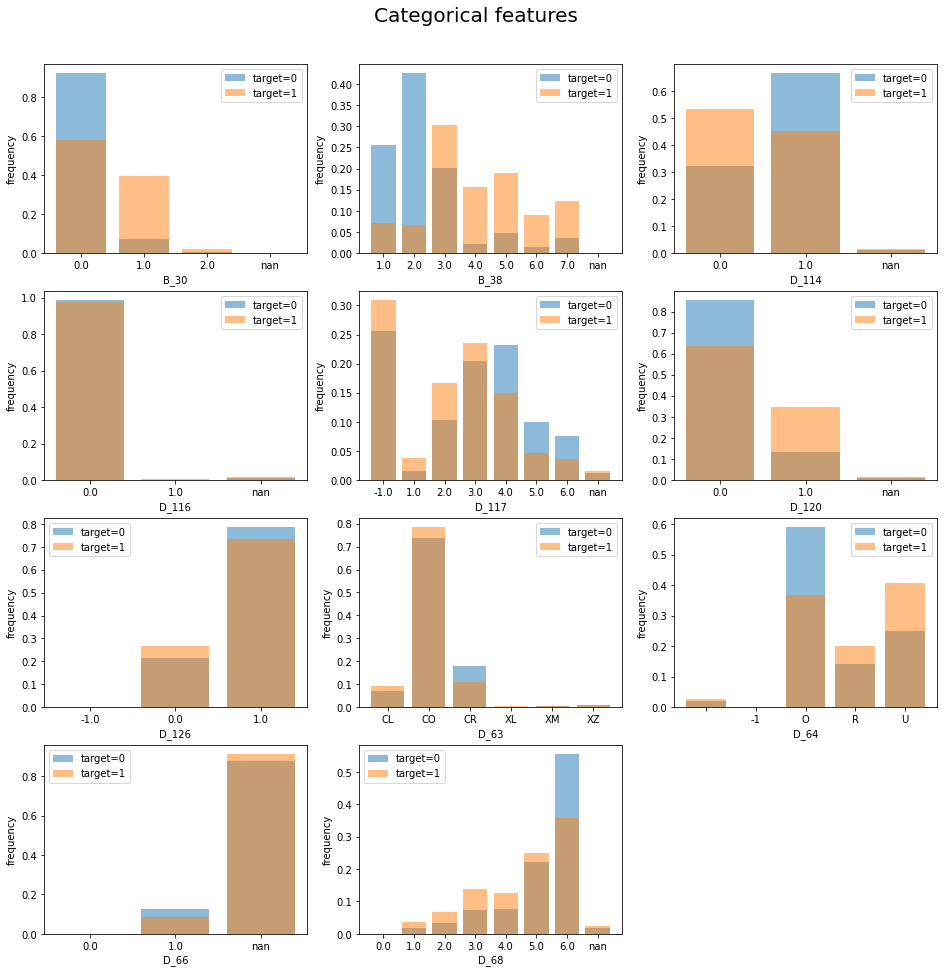

In [16]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
    plt.subplot(4, 3, i+1)
    temp = pd.DataFrame(df_train[f][df_train.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(df_train[f][df_train.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical features', fontsize=20, y=0.93)
plt.show()
del temp

### Skewness Representation

In [17]:
columns=list(df_train.columns)
columns.remove('target')
columns.remove('S_2')
columns

['P_2',
 'D_39',
 'B_1',
 'B_2',
 'R_1',
 'S_3',
 'D_41',
 'B_3',
 'D_42',
 'D_43',
 'D_44',
 'B_4',
 'D_45',
 'B_5',
 'R_2',
 'D_46',
 'D_47',
 'D_48',
 'D_49',
 'B_6',
 'B_7',
 'B_8',
 'D_50',
 'D_51',
 'B_9',
 'R_3',
 'D_52',
 'P_3',
 'B_10',
 'D_53',
 'S_5',
 'B_11',
 'S_6',
 'D_54',
 'R_4',
 'S_7',
 'B_12',
 'S_8',
 'D_55',
 'D_56',
 'B_13',
 'R_5',
 'D_58',
 'S_9',
 'B_14',
 'D_59',
 'D_60',
 'D_61',
 'B_15',
 'S_11',
 'D_62',
 'D_63',
 'D_64',
 'D_65',
 'B_16',
 'B_17',
 'B_18',
 'B_19',
 'D_66',
 'B_20',
 'D_68',
 'S_12',
 'R_6',
 'S_13',
 'B_21',
 'D_69',
 'B_22',
 'D_70',
 'D_71',
 'D_72',
 'S_15',
 'B_23',
 'D_73',
 'P_4',
 'D_74',
 'D_75',
 'D_76',
 'B_24',
 'R_7',
 'D_77',
 'B_25',
 'B_26',
 'D_78',
 'D_79',
 'R_8',
 'R_9',
 'S_16',
 'D_80',
 'R_10',
 'R_11',
 'B_27',
 'D_81',
 'D_82',
 'S_17',
 'R_12',
 'B_28',
 'R_13',
 'D_83',
 'R_14',
 'R_15',
 'D_84',
 'R_16',
 'B_29',
 'B_30',
 'S_18',
 'D_86',
 'D_87',
 'R_17',
 'R_18',
 'D_88',
 'B_31',
 'S_19',
 'R_19',
 'B_32',
 

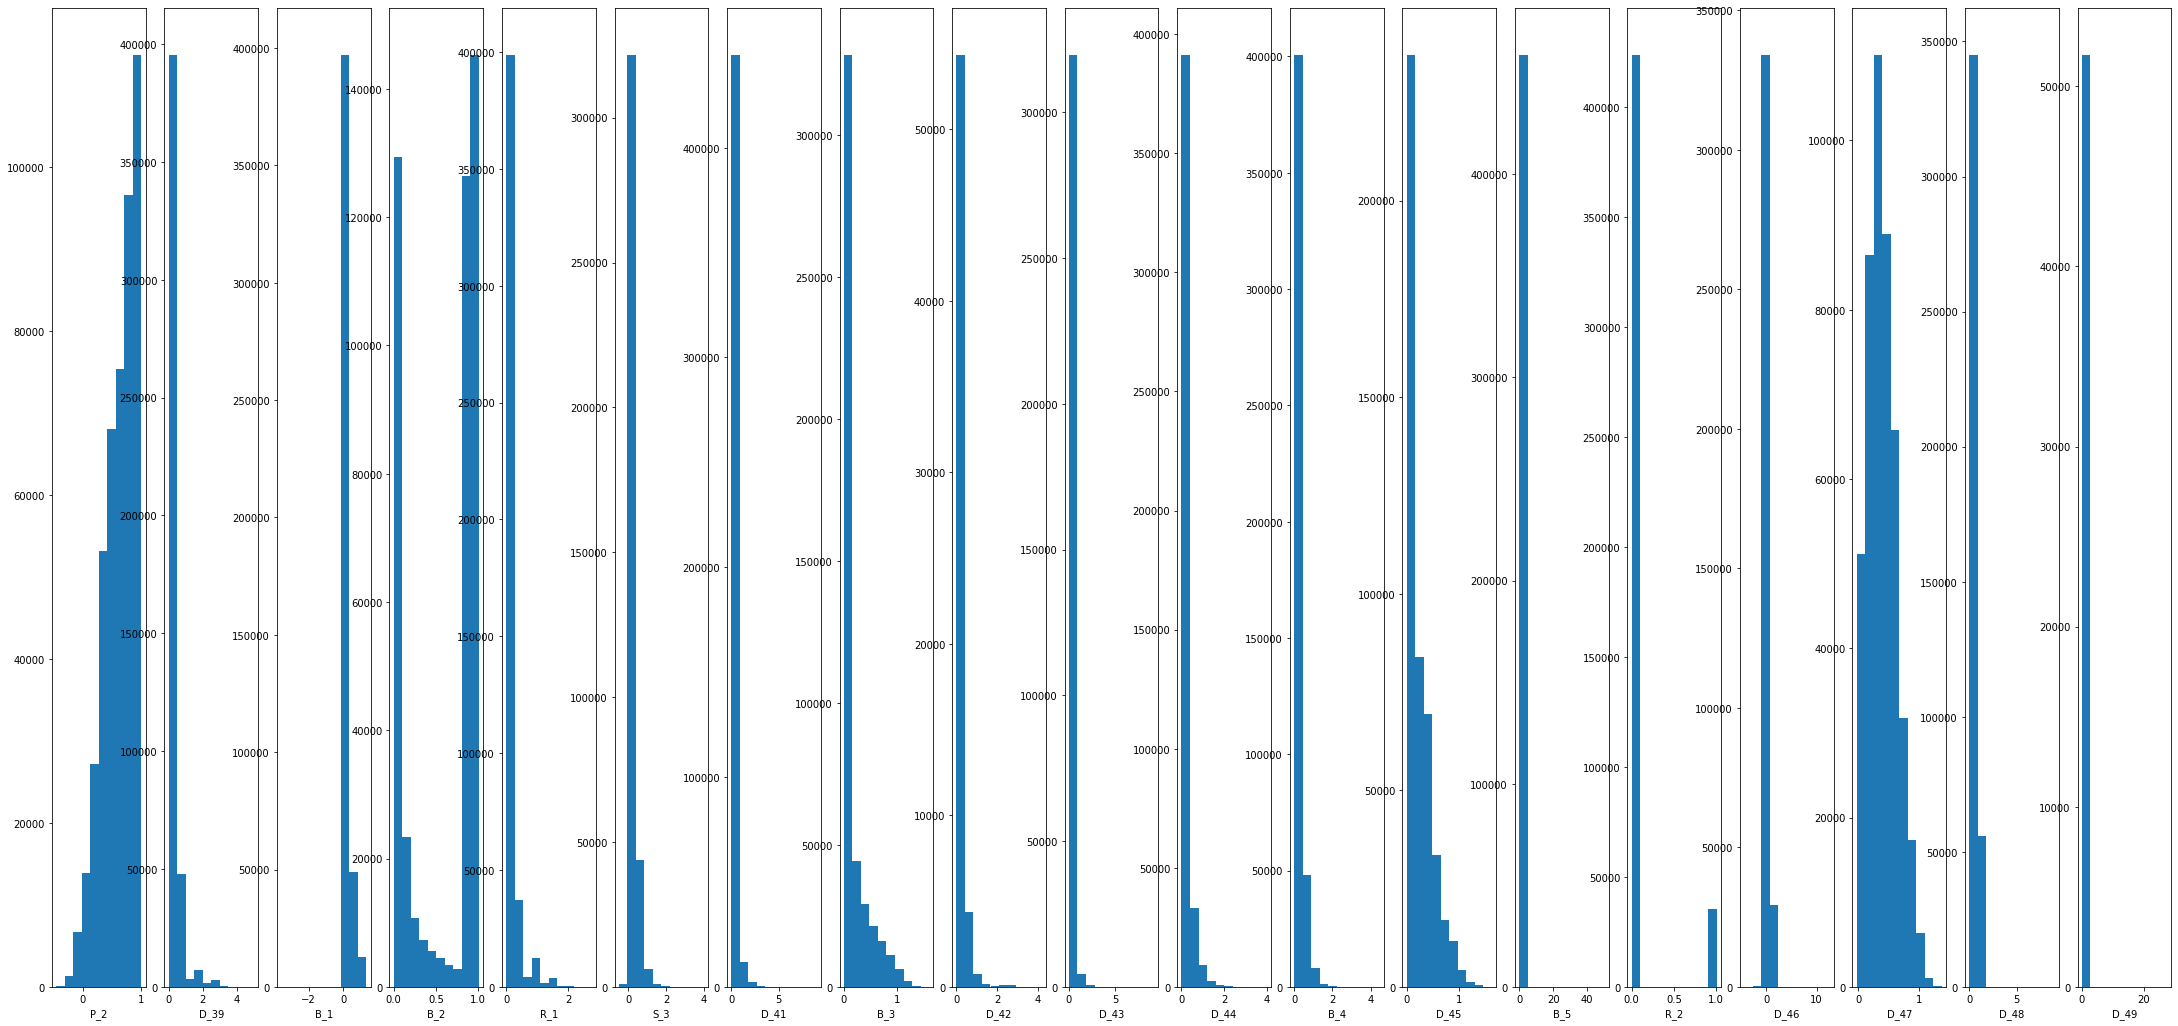

In [18]:
fig = plt.figure(figsize=(40,18))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(1,20):
  fig.add_subplot(1,20,i)
  plt.hist(x=df_train[columns[i-1]])
  plt.xlabel(columns[i-1])